# PIG et JSON et streaming avec les données vélib - énoncé

Manipulation de données JSON en Map/Reduce avec [PIG](https://pig.apache.org/).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Récupération des données

Les données ne se présentent pas toujours sous forme de tables. Elles sont parfois non structurées comme c'est le cas des données vélib qui sont décrites au format [JSON](http://fr.wikipedia.org/wiki/JavaScript_Object_Notation). Le premier jeu de données est le décompte des vélos et places disponibles toutes les minutes le 11 novembre 2014 entre 22h et 23h à Paris. Ces données ont été accumulées grâce au programme [collect Velib data](http://www.xavierdupre.fr/app/pyensae/helpsphinx/all_example.html#collect-velib-data).

In [2]:
import pyensae.datasource
%load_ext pyensae
%load_ext pyenbc
import os, datetime

In [3]:
if not os.path.exists("velib") : os.mkdir("velib")
files=pyensae.datasource.download_data("data_velib_paris_2014-11-11_22-23.zip", website="xdtd", whereTo="velib")
files[:2]

['velib\\paris.2014-11-11_22-00-18.331391.txt',
 'velib\\paris.2014-11-11_22-01-17.859194.txt']

On regarde un extrait :

In [4]:
with open("velib/paris.2014-11-11_22-00-18.331391.txt","r",encoding="utf-8")as f :
    text = f.read()
text[:300] + "..."

"[{'address': 'RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) - 93170 BAGNOLET', 'collect_date': datetime.datetime(2014, 11, 11, 22, 0, 18, 628226), 'lng': 2.416170724425901, 'contract_name': 'Paris', 'name': '31705 - CHAMPEAUX (BAGNOLET)', 'banking': 0, 'lat': 48.8645278209514, 'bonus': 0, 'status': '..."

Les données ont été sauvegardées au format Python si bien que la fonction [eval](https://docs.python.org/3.4/library/functions.html#eval) suffit à les récupérer.

In [5]:
data = eval(text)
data[:2]

[{'name': '31705 - CHAMPEAUX (BAGNOLET)',
  'available_bikes': 1,
  'status': 'OPEN',
  'number': 31705,
  'lng': 2.416170724425901,
  'available_bike_stands': 49,
  'contract_name': 'Paris',
  'address': 'RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) - 93170 BAGNOLET',
  'last_update': datetime.datetime(2014, 11, 11, 21, 55, 22),
  'lat': 48.8645278209514,
  'bike_stands': 50,
  'collect_date': datetime.datetime(2014, 11, 11, 22, 0, 18, 628226),
  'bonus': 0,
  'banking': 0},
 {'name': '10042 - POISSONNIÈRE - ENGHIEN',
  'available_bikes': 32,
  'status': 'OPEN',
  'number': 10042,
  'lng': 2.348395236282807,
  'available_bike_stands': 1,
  'contract_name': 'Paris',
  'address': "52 RUE D'ENGHIEN / ANGLE RUE DU FAUBOURG POISSONIERE - 75010 PARIS",
  'last_update': datetime.datetime(2014, 11, 11, 21, 59, 5),
  'lat': 48.87242006305313,
  'bike_stands': 33,
  'collect_date': datetime.datetime(2014, 11, 11, 22, 0, 18, 628226),
  'bonus': 0,
  'banking': 0}]

Et on peut les rassembler dans un DataFrame :

In [6]:
import pandas
df = pandas.DataFrame(data)
df.head(n=2)

address  available_bike_stands  \
0  RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) -...                     49   
1  52 RUE D'ENGHIEN / ANGLE RUE DU FAUBOURG POISS...                      1   

   available_bikes  banking  bike_stands  bonus               collect_date  \
0                1        0           50      0 2014-11-11 22:00:18.628226   
1               32        0           33      0 2014-11-11 22:00:18.628226   

  contract_name         last_update        lat       lng  \
0         Paris 2014-11-11 21:55:22  48.864528  2.416171   
1         Paris 2014-11-11 21:59:05  48.872420  2.348395   

                             name  number status  
0    31705 - CHAMPEAUX (BAGNOLET)   31705   OPEN  
1  10042 - POISSONNIÈRE - ENGHIEN   10042   OPEN

Chaque ligne donne le nombre de places ``available_bike_stands`` et le nombre de vélos ``available_bikes`` disponibles à la date ``collect_date``. La colone ``last_update`` contient l'heure du dernier retrait ou de la dernière pose de vélo à cette station. Il y plus d'un millier de stations à Paris (voir [carte](http://www.velib.paris.fr/Plan-stations)).

In [7]:
df.shape

(1229, 14)

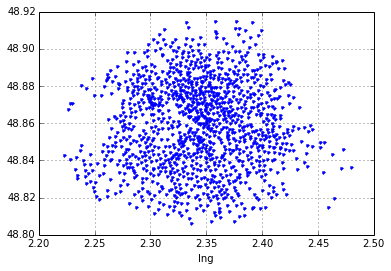

In [8]:
df.plot(x="lng",y="lat",style=".",xlim=[2.20, 2.50])

L'objectif est de calculer des statistiques sur ce petit jeu de données puis de calculer ces mêmes statistiques sur des jeux plus grands. Et on va essayer de ne pas transformer les données localement. Elles vont être uploadés sur le cluster au format JSON.

## Conversion des données en streaming

Le format [JSON](http://fr.wikipedia.org/wiki/JavaScript_Object_Notation) telle que l'accepte PIG stipule que chaque ligne (ou observation) doit suivre le format ``{ id1: JSON, id2:valeur2, ... }``. Les chaînes de caractères doivent être entourées de guillements ``"``. Il faudrait donc modifier les fichiers précédents de telle sorte qu'ils suivent ce schéma. On pourrait faire quelque chose comme ceci :

In [9]:
import json

class DateTimeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, datetime.datetime):
            encoded_object = "%04d-%02d-%02dT%02d:%02d:%02d"% (obj.timetuple()[:6] )
        else:
            encoded_object =json.JSONEncoder.default(self, obj)
        return encoded_object

files = [ os.path.join("velib",_) for _ in os.listdir("velib") if "paris" in _ and _.endswith(".txt") ]
for f in files :
    print("*****",f)
    with open(f, "r", encoding="utf8") as h:
        for row in h:
            js = eval(row)
            sjs = json.dumps( { "minute":js }, cls = DateTimeEncoder )  # essayer sans le paramètre cls pour
                                                                        # voir l'erreur que cela produit
            print(sjs [:400] + "...")
    break

***** velib\paris.2014-11-11_22-00-18.331391.txt
{"minute": [{"name": "31705 - CHAMPEAUX (BAGNOLET)", "available_bikes": 1, "status": "OPEN", "number": 31705, "lng": 2.416170724425901, "available_bike_stands": 49, "contract_name": "Paris", "address": "RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) - 93170 BAGNOLET", "last_update": "2014-11-11T21:55:22", "lat": 48.8645278209514, "bike_stands": 50, "collect_date": "2014-11-11T22:00:18", "bonus": 0, ...


Toutefois, cette conversion pourrait tout aussi bien se produire sur le cluster. C'est ce qu'on va implémenter avec l'instruction [STREAM](http://pig.apache.org/docs/r0.8.1/piglatin_ref2.html#STREAM). Celle-ci permet d'insérer du code écrit en n'importe quel langage dans un script PIG.

Côté python, le **streaming** se résume à l'écriture d'un programme qui écoute l'entrée standard et retourne des résultats sur la sorties standard. Il faut écrire selon une syntaxe acceptée par Python 2 et 3. Ce notebook marche avec Python 3, la version sur le cluster est le plus souvent 2.7. Cela signifie aussi que les modules en local ne sont pas forcément installés sur le cluster.

In [10]:
%%PYTHON stream_json.py

import sys, datetime
cols = [ _ for _ in sys.argv if ".py" not in _ ]
for row in sys.stdin:
    row = row.strip()
    if len(row) == 0 :
        continue
    js = eval(row)
    for station in js:
        vals = [ str(station[c]) for c in cols ]
        sys.stdout.write(",".join(vals))
        sys.stdout.write("\n")
        sys.stdout.flush()

On teste sur quelques exemples que le script fonctionne :

In [11]:
%%runpy stream_json.py name status
[{'address': 'RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) - 93170 BAGNOLET', 'collect_date': datetime.datetime(2014, 11, 11, 22, 2, 18, 47270), 'lng': 2.416170724425901, 'contract_name': 'Paris', 'name': '31705 - CHAMPEAUX (BAGNOLET)', 'banking': 0, 'lat': 48.8645278209514, 'bonus': 0, 'status': 'OPEN', 'available_bikes': 1, 'last_update': datetime.datetime(2014, 11, 11, 21, 55, 22), 'number': 31705, 'available_bike_stands': 49, 'bike_stands': 50}]
[{'address': 'RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) - 93170 BAGNOLET', 'collect_date': datetime.datetime(2014, 11, 11, 22, 2, 18, 47270), 'lng': 2.416170724425901, 'contract_name': 'Paris', 'name': '31705 - CHAMPEAUX (BAGNOLET)', 'banking': 0, 'lat': 48.8645278209514, 'bonus': 0, 'status': 'OPEN', 'available_bikes': 1, 'last_update': datetime.datetime(2014, 11, 11, 21, 55, 22), 'number': 31705, 'available_bike_stands': 49, 'bike_stands': 50}]

Ca fonctionne. On passe au cluster maintenant.

## Connexion au cluster

Dans un premier temps, on prend le cluster [Cloudera](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td3a_cenonce_session6.html#p2). Il faut exécuter ce script pour pouvoir notifier au notebook que la variable ``params`` existe.

In [12]:
import pyensae
from pyquickhelper.ipythonhelper import open_html_form
params={"server":"df...fr", "username":"", "password":""}
open_html_form(params=params,title="server + credentials", key_save="params")

In [13]:
import pyensae
%load_ext pyensae
password = params["password"]
server = params["server"]
username = params["username"]
client = %remote_open
client

## Upload version

On créé un répertoire sur le cluster :

In [14]:
%dfs_mkdir velib_py

('', '')

In [15]:
%dfs_ls .

attributes code        alias       folder    size        date   time  \
0  drwx------    -  xavierdupre  xavierdupre       0  2014-11-21  01:05   
1  drwx------    -  xavierdupre  xavierdupre       0  2014-11-21  01:06   
2  -rw-r--r--    3  xavierdupre  xavierdupre  132727  2014-11-16  02:37   
3  drwxr-xr-x    -  xavierdupre  xavierdupre       0  2014-11-16  02:38   
4  -rw-r--r--    3  xavierdupre  xavierdupre  461444  2014-11-20  01:33   
5  drwxr-xr-x    -  xavierdupre  xavierdupre       0  2014-11-20  23:43   
6  drwxr-xr-x    -  xavierdupre  xavierdupre       0  2014-11-20  22:29   
7  drwxr-xr-x    -  xavierdupre  xavierdupre       0  2014-11-21  01:05   
8  drwxr-xr-x    -  xavierdupre  xavierdupre       0  2014-11-20  01:53   
9  drwxr-xr-x    -  xavierdupre  xavierdupre       0  2014-11-21  01:06   

                                          name  isdir  
0                                       .Trash   True  
1                                     .staging   True  
2           ConfLongDemo_JSI.small.example.txt  False  
3  ConfLongDemo_JSI.small.example2.walking.txt   True  
4         paris.2014-11-11_22-00-18.331391.txt  False  
5                                     unitest2   True  
6                                     unittest   True  
7                                    unittest2   True  
8                                   velib_1hjs   True  
9                                     velib_py   True

In [16]:
files = [ os.path.join("velib",_) for _ in os.listdir("velib") if "paris" in _ and _.endswith(".txt")]
for i,f in enumerate(files[51:]) :
    if i % 10 == 0 : print(i,"/",len(files),f)
    filename = os.path.split(f)[-1]
    f = os.path.abspath(f)
    client.upload_cluster(f, "velib_py")

0 / 61 velib\paris.2014-11-11_22-51-17.300775.txt


On crée le répertoire de résultats :

In [17]:
%dfs_mkdir velib_py_results

('', '')

## PIG, pseudo JSON et streaming

On a créé plus haut le script python capable d'interpréter du python puis d'extraire les informations voulues. On va maintenant dire à PIG d'envoyer chaque ligne qu'il va charger (instruction ``LOAD``) au script python (instruction ``STREAM``). On lui dit de récuper les informations selon un certain format.

La seconde ligne ``DEFINE`` définit la commande utilisée. Elle précise également que le script ``pystream.py`` devra être envoyé à toutes les machines du cluster participant au job. Et il faut attention, cette ligne ne comporte pas que des apostrophes, le caractère **' incliné** est très important.

Les premiers essais de streaming sont souvent douloureux.

In [18]:
%%PIG json_velib.pig

DEFINE pystream `python stream_json.py available_bike_stands available_bikes lat lng name status` SHIP ('stream_json.py') INPUT(stdin USING PigStreaming(',')) OUTPUT (stdout USING PigStreaming(',')) ;

jspy = LOAD 'velib_py/*.txt' USING PigStorage('\t') AS (arow:chararray);

matrice = STREAM jspy THROUGH pystream AS 
                (   available_bike_stands:chararray, 
                    available_bikes:chararray, 
                    lat:double, 
                    lng:double, 
                    name:chararray, 
                    status:chararray) ;

STORE matrice INTO 'velib_py_results/firstjob' USING PigStorage('\t') ;

Pour supprimer les précédents résultats :

In [19]:
if client.dfs_exists("velib_py_results/firstjob"):
    client.dfs_rm("velib_py_results/firstjob", recursive=True)
%dfs_mkdir velib_py_results

("Moved: 'hdfs://nameservice1/user/xavierdupre/velib_py_results/firstjob' to trash at: hdfs://nameservice1/user/xavierdupre/.Trash/Current\n",
 '14/11/21 01:50:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 1440 minutes, Emptier interval = 0 minutes.\n')

On exécute le job :

In [20]:
%pig_submit json_velib.pig stream_json.py -r redirection

In [21]:
%remote_ls .

attributes         code   alias folder  size   unit  \
-rw-rw-r-- 1  xavierdupre  xavierdupre       0    Nov    21  01:43   
           1  xavierdupre  xavierdupre     650    Nov    21  01:50   
           1  xavierdupre  xavierdupre  523646    Nov    21  01:15   
           1  xavierdupre  xavierdupre    3077    Nov    21  01:24   
           1  xavierdupre  xavierdupre    3297    Nov    21  01:37   
           1  xavierdupre  xavierdupre     672    Nov    21  01:43   
           1  xavierdupre  xavierdupre     382    Nov    21  01:43   
           1  xavierdupre  xavierdupre     860    Nov    21  01:50   
           1  xavierdupre  xavierdupre       0    Nov    21  01:50   
           1  xavierdupre  xavierdupre     356    Nov    21  01:50   

                                              name  isdir  
-rw-rw-r-- 1                                 dummy  False  
           1                        json_velib.pig  False  
           1  paris.2014-11-11_22-50-17.777867.txt  False  
           1                 pig_1416529443864.log  False  
           1                 pig_1416530241713.log  False  
           1                          pystream.pig  False  
           1                           pystream.py  False  
           1                       redirection.err  False  
           1                       redirection.out  False  
           1                        stream_json.py  False

S'il se produit des erreurs, il est recommandé d'afficher plus de lignes :

In [22]:
%remote_cmd tail redirection.pig.err

On vérifie que tout s'est bien passé. La taille devrait être équivalent à l'entrée.

In [23]:
%dfs_ls velib_py_results

attributes code        alias       folder size        date   time  \
0  drwxr-xr-x    -  xavierdupre  xavierdupre    0  2014-11-21  01:51   

                        name isdir  
0  velib_py_results/firstjob  True

In [24]:
if os.path.exists("velib_hd.txt") : os.remove("velib_hd.txt")
client.download_cluster("velib_py_results/firstjob","velib_hd.txt", merge=True)

'velib_py_results/firstjob'

In [25]:
%head velib_hd.txt -n 5

In [26]:
import pandas
df = pandas.read_csv("velib_hd.txt", sep="\t",names=["available_bike_stands","available_bikes","lat","lng","name","status"])
df.head()

available_bike_stands  available_bikes        lat       lng  \
0                     47                3  48.864528  2.416171   
1                      5               28  48.872420  2.348395   
2                     42                1  48.882149  2.319860   
3                      5               31  48.868217  2.330494   
4                     20                5  48.893269  2.412716   

                             name status  
0    31705 - CHAMPEAUX (BAGNOLET)   OPEN  
1  10042 - POISSONNIÈRE - ENGHIEN   OPEN  
2              08020 - METRO ROME   OPEN  
3          01022 - RUE DE LA PAIX   OPEN  
4      35014 - DE GAULLE (PANTIN)   OPEN

In [27]:
df.shape

(73740, 6)

## Exercice 1 : convertir les valeurs numériques

## Exercice 2 : stations fermées
    
Les stations fermées ne le sont pas tout le temps. On veut calculer le ratio vélo/minute/station fermées / total des vélo/minute/station.

## Exercice 3 : stations fermées, journée complète
    
Appliquer cela à une journée complète.

## Exercice 4 : astuces

Les erreurs de PIG ne sont pas très explicite surtout si elles se produisent dans le script python. Un moyen simple de débugger est d'attraper les exceptions produites par python et de les récupérer sous PIG (le reste du job est enlevé). On peut tout-à-fait imaginer ajouter la version de python installée sur le cluster ainsi que la liste de modules